In [1]:
# from sklearn.datasets import make_multilabel_classification
from torch.utils.data import Dataset
import json
import numpy as np
import torch
import time
from tqdm import tqdm

from preprocessing import for_train

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# X, y = for_train("word", p=-1)
X, y = for_train("word", p=0.20250)

delet some useless data: 100%|██████████| 25793/25793 [00:00<00:00, 236459.31it/s]


Number of instance with label :  7460
Number of instance without label(remain) :  1894


authors: 100%|██████████| 25793/25793 [00:08<00:00, 3041.69it/s]


In [3]:
print(X.shape)

N_FEATURES = X.shape[1]

torch.Size([9354, 4999])


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# X_train = X
# X_test = X
# y_train = y
# y_test = y

print("Train:")
print("     X_train : ", X_train.shape)
print("     y_train : ", y_train.shape)
print("Test_Kaggle:")
print("     X_test  : ", X_test.shape)
print("     y_test  : ", y_test.shape)


Train:
     X_train :  torch.Size([7483, 4999])
     y_train :  torch.Size([7483, 100])
Test_Kaggle:
     X_test  :  torch.Size([1871, 4999])
     y_test  :  torch.Size([1871, 100])


In [5]:
from NN_Models import *

In [6]:
print(f"[INFO]: Number of training samples: {X_train.shape[0]}")
print(f"[INFO]: Number of training features: {X_train.shape[1]}")

# train data loader
train_dataset, train_dataloader = BinaryDataLoader(X_train, y_train, shuffle=True, batch_size=100)

# initialize the model
model = SentenceRNN()

[INFO]: Number of training samples: 7483
[INFO]: Number of training features: 4999


In [7]:
import torch.optim as optim

learning_rate = 0.001
loss_func = "MSE"

# learning parameters
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate) # 学习率衰减 / 学习率震荡
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100

# load the model on to the computation device
model.to(device)

SentenceRNN(
  (lstm): LSTM(4999, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=100, bias=True)
)

In [8]:
import torch

# start the training
start = time.time()
train_loss = []
print(f"Epochs        : {epochs} ")
print(f"learning rate : {learning_rate}")
print(f"loss function : {loss_func}")

for epoch in range(epochs):

    # print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_dataloader, optimizer, loss_fn, train_dataset, device, lstm=True, loss_func=loss_func
    )
    train_loss.append(train_epoch_loss)
    # print(f"Train Loss: {train_epoch_loss:.4f}")
torch.save(model.state_dict(), 'status/model_words.pth')

print("="*25)
print(time.time()-start, 's')

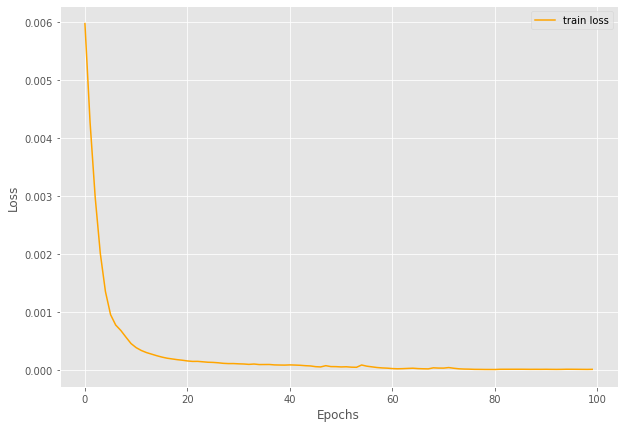

In [54]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

# plot and save the train loss graph
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('outputs/multi_head_binary_loss.png')
plt.show()

### Test (ignore when submit kaggle)

In [46]:
# print some info
print(f"[INFO]: Number of testing samples: {X_test.shape[0]}")
print(f"[INFO]: Number of testing features: {X_test.shape[1]}")

# test data loader
X_test, y_test = for_train("word", p=0.20250)

test_dataset, test_dataloader = BinaryDataLoader(X_test, y_test, shuffle=False, batch_size=1)

[INFO]: Number of testing samples: 9354
[INFO]: Number of testing features: 4999


delet some useless data: 100%|██████████| 25793/25793 [00:00<00:00, 266939.61it/s]

Number of instance with label :  7460
Number of instance without label(remain) :  1894



authors: 100%|██████████| 25793/25793 [00:07<00:00, 3582.33it/s]


In [47]:
model = SentenceRNN()
model.load_state_dict(torch.load('status/model_words.pth'))
model.to(device)
model.eval()

SentenceRNN(
  (lstm): LSTM(4999, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=100, bias=True)
)

In [48]:
from preprocessing import *

target_list = transform_labels(y_test, threshold=1)

In [49]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

def get_f1(threshold):
    predict_list = []

    for i, test_sample in enumerate(test_dataloader):
        
        features = test_sample['features']
        
        
        features = torch.reshape(features, (features.shape[0], 1, features.shape[1])).to(device)
        
        outputs = model(features)
        
        outputs = outputs.squeeze()
                
        # get all the labels
        predict_list.append(transform_to_label(outputs, threshold=threshold))

    return predict_list, f1_score(target_list, predict_list, average='weighted')

In [50]:
thresholds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
f1_scores = []

for i in tqdm(range(len(thresholds))):
    threshold = thresholds[i]

    predict_list, f1 = get_f1(threshold)

    f1_scores.append(f1)

100%|██████████| 9/9 [10:06<00:00, 67.37s/it]


In [51]:
THRESHOLD = thresholds[f1_scores.index(max(f1_scores))]
THRESHOLD

0.1

In [52]:
# max(f1_scores)
f1_scores

[0.799896334777076,
 0.8763555816181507,
 0.8795921527220626,
 0.8807861738948699,
 0.8791951923966211,
 0.8769363930649806,
 0.8729982482407432,
 0.8695875018099826,
 0.8669498145128807]

# Kaggle Predictions

In [53]:
from preprocessing import for_kaggle

X_kaggle = for_kaggle('word')

# print some info
print(f"[INFO]: Number of testing samples: {X_kaggle.shape[0]}")
print(f"[INFO]: Number of testing features: {X_kaggle.shape[1]}")

# train data loader
kaggle_dataloader = BinaryDataLoader(X_kaggle, None, shuffle=False, batch_size=1)

predict_dict = {}

# for i, test_sample in tqdm(enumerate(kaggle_dataloader), total=len(kaggle_dataloader)):
key = 0
for test_sample in tqdm(X_kaggle):
    # print(f"SAMPLE {i}")
    # extract the features and labels
    features = test_sample
    
    features = torch.reshape(features, (1, 1, 4999))
    
    outputs = model(features)
    outputs = outputs.squeeze()
    tmp = {}
    
    for i in range(100):
        tmp[i] = outputs[i].item()
         
    predict_dict[key] = tmp
    
    key += 1

# with open('outputs/abstracts_title.json', 'w') as fp:
#     json.dump(predict_dict, fp)

with open('outputs/abstracts_title_all.json', 'w') as fp:
    json.dump(predict_dict, fp)

title & abstract: 100%|██████████| 800/800 [00:02<00:00, 363.66it/s]


[INFO]: Number of testing samples: 800
[INFO]: Number of testing features: 4999


100%|██████████| 800/800 [00:03<00:00, 251.08it/s]
